$$\require{mhchem}$$       

# Homework 11
## Pengfei Cheng
## AndrewID: pengfeic

# Non-isothermal PFR

The gas-phase oxidation of o-xylene to phthalic anhydride is highly exothermic.  The reaction is carried out PFR bundles with molden salt circulating as the heat transfer fluid.  The o-xylene is mixed with air before entering the PFR. The reaction rate is limited by maintaining a low concentration of hydrocarbon in the feed. The mol fraction of o-xylene is less than 2%.  
\begin{align}
\text{o-xylene} \rightarrow \text{phthalic anhydride} 
\end{align}

Under these conditions, the large excess of oxygen leads to a pseudo-first-order rate expression:
\begin{align*}
r=k_m \exp \left[-E\left(\frac{1}{T}-\frac{1}{T_m}\right)\right] c_x 
\end{align*}
where $c_x$ is the o-xylene concetration.  The operating pressure is atmospheric.  

| Parameter   |      Value                  | Units        |
|-------------|----------------------------|--------------|
| $k_m$       | 2.0822                 | 1/s          |
| $T_A$       | 625                    | K            |
| $T_m$       | 625                    | K            |
| $P_f$       | 1.0                    | atm          |
| l           | 1.5                    | m            |
| R           | 0.0125                 | m            |
| $\hat{C}_p$ | 0.992                  | kJ/kg K      |
| U           | 0.373                  | kJ/m$^2$ s K |
| $y_{xf}$      | 0.019                  |              |
| E/R         | $1.3636\times 10^4$    | K            |
| $\Delta H_R$ | $-1.284 \times 10^6$   | kJ/kmol       |
| $Q\rho$     | $2.6371\times 10^{-3}$ | kg/s         |

$y_{xf}$ is the mol fraction of xylene in the feed. The rest is inert.  The specific heat is constant.  $T_m$ is the reference temperature. $T_a$ is the temperature of the coolant.  The average molecular weight of the inlet feed is 30.387 kg/kmol.

## Part A
Calculate the temperature and o-xylene composition profiles for inlet feed temperatures of 610 to 630 K.

In [77]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve, minimize

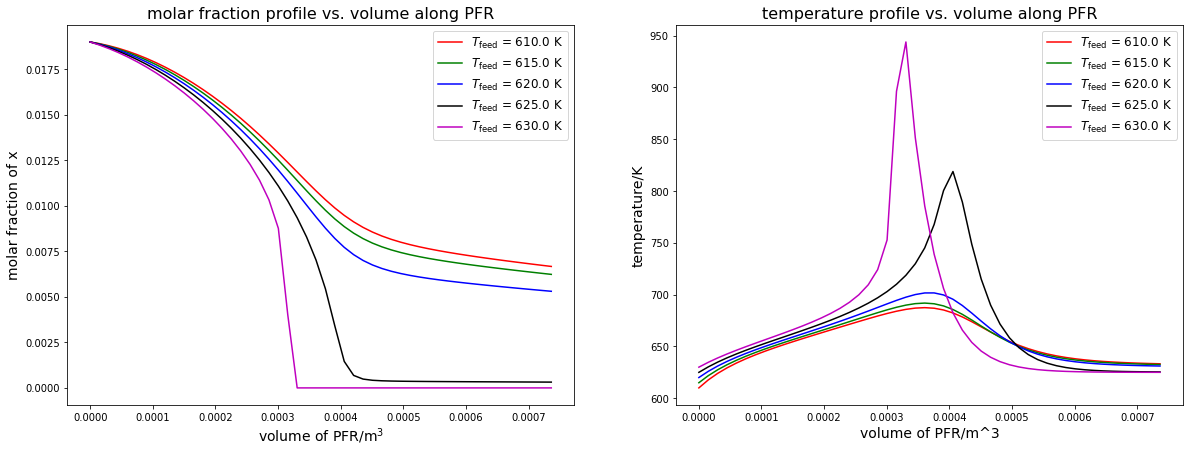

In [100]:
# input parameters

km = 2.0822           # 1/s, reaction rate
E = 1.3636e4          # K, stands for 'E/R'

Cp_hat = 0.992        # kJ/kg/K, heat capacity
DH_R = -1.284e6       # kJ/mol, reaction enthalpy
U = 0.373             # kJ/m^2/s/K, overall heat transfer rate (area specific)

TA = 625              # K, coolent temperature
Tm = 625              # K, reference temperature
Pf = 1.0              # atm, operation pressure
l = 1.5               # m, the length of PFR
R = 0.0125            # m, the radius of PFR

yx_feed = 0.019       # mole fraction of o-xylene in the feed
Q_rho = 2.6371e-3     # kg/s, mass flowrate

MW = 30.387           # kg/kmol, average molecular weight

V = np.pi * R ** 2 * l                   # m^3, volume of PFR
a = 2 * np.pi * R / (np.pi * R ** 2)     # 1/m, area to surface ratio



# set initial conditions

FT_feed = Q_rho / MW         # kmol/s
Fx_feed = FT_feed * yx_feed  # inlet molar flowrate of x
Finert = FT_feed - Fx_feed   # molar flowrate of inert




# build the function for PFR ODEs

def PFR_A(Y, V, T_feed):
    '''functions to calculate the molar flowrate & temperature profile along the PFR'''
    Fx, T = Y
    
    # calculate volumetric flowrate
    rho = Pf * 101325 * MW / 8.314 / T_feed / 1e3   # kg / m3, density
    nu0 = Q_rho / rho            # m^3/s, inlet volume flowrate
    nu = nu0 * T / T_feed
    
    # calculate the reaction rate
    cx = Fx / nu # kmol / m^3
    r = km * np.exp(- E * (1 / T - 1 / Tm)) * cx # kmol / m^3 / s
    
    # calculate the rate of temperature changing
    dTdV = (- DH_R * r + U * a * (TA - T)) / (Cp_hat * Q_rho) # K/s
    
    return [-r, dTdV]



# integrate & plot the results

Vspan = np.linspace(0, V)

T_feed_span = np.linspace(610, 630, 5)

plt.figure(figsize = (20, 7))

colors = 'rgbkm'

for i, T_feed in enumerate(T_feed_span):
    Y0 = [Fx_feed, T_feed]
    sol = odeint(PFR_A, Y0, Vspan, args = (T_feed, ))
    
    Fx = sol[:, 0]
    yx = Fx / FT_feed

    plt.subplot(1, 2, 1)
    plt.plot(Vspan, yx, label = '$T_\mathrm{feed}$ = ' + str(T_feed) + ' K', color=colors[i])
    plt.xlabel('volume of PFR/$\mathrm{m}^3$', fontsize = 14)
    plt.ylabel('molar fraction of x', fontsize = 14)
    plt.title('molar fraction profile vs. volume along PFR', fontsize = 16)
    plt.legend(fontsize = 12)

    plt.subplot(1, 2, 2)
    plt.plot(Vspan, sol[:, 1], label = '$T_\mathrm{feed}$ = ' + str(T_feed) + ' K', color=colors[i])
    plt.xlabel('volume of PFR/m^3', fontsize = 14)
    plt.ylabel('temperature/K', fontsize = 14)
    plt.title('temperature profile vs. volume along PFR', fontsize = 16)
    plt.legend(fontsize = 12)

plt.show()

## Part B
What is the maximum feed temperature that can be used that keeps the maximum reactor temperature below 700 K?

In [102]:
# define objective function

def obj_B(T_feed):
    
    T_feed, = T_feed
    Y0 = [Fx_feed, T_feed]
    sol_tmp = odeint(PFR_A, Y0, Vspan, args = (T_feed, ))
    
    T = sol_tmp[:, 1]
    T_max = np.amax(T)
    
    return T_max - 700

T_feed_max, = fsolve(obj_B, 619)

print('The maximum feed T is {:1.2f} K that keeps the maximum reactor T below 700 K.'.format(T_feed_max))

The maximum feed T is 619.45 K that keeps the maximum reactor T below 700 K.


## Part C
We learn that the reaction is reversible.  Calculate the equilibrium constant as a function of temperature from 625 to 800 K on a y-log scale

The reference equilibrium constant at 625 K is $10^8$.  

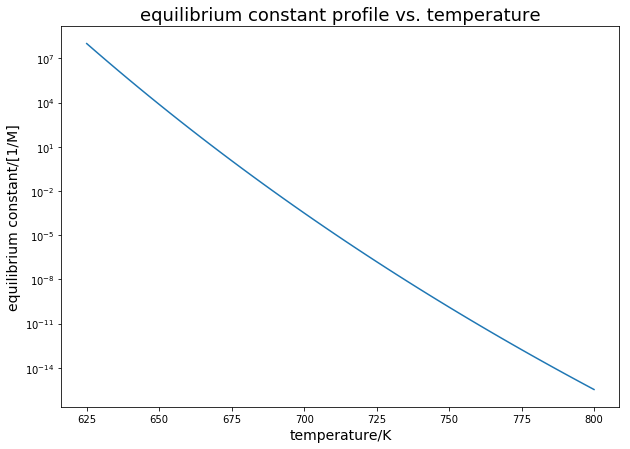

In [103]:
Km = 1e8 # reference equilibrium constant at 625 K
R = 8.314 # J/mol/K

# define K function

def K_eq(T):
    return Km * np.exp(- DH_R / R * (1 / T - 1 / Tm))

Tspan = np.linspace(625, 800)

plt.figure(figsize=(10, 7))
plt.semilogy(Tspan, K_eq(Tspan))
plt.xlabel('temperature/K', fontsize = 14)
plt.ylabel('equilibrium constant/[1/M]', fontsize = 14)
plt.title('equilibrium constant profile vs. temperature', fontsize = 18)
plt.show()

## Part D
Calculate the temperature and o-xylene composition profile for this reversible scenario for inlet feed temperatures of 610 to 630 K.  Explain what's happening.  

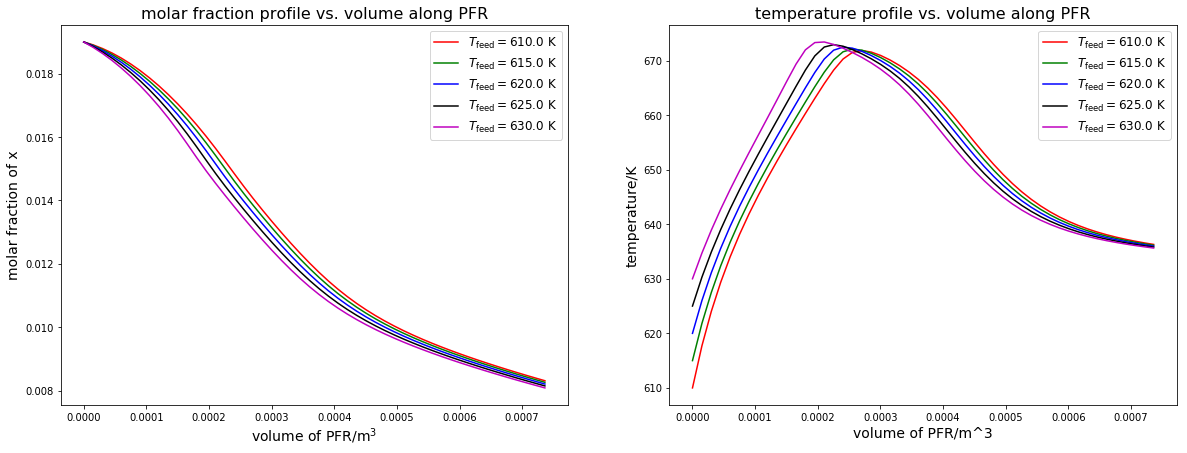

In [104]:
# build the function for PFR ODEs, taking equilibrium constant into account

def PFR_D(Y, V, T_feed):
    '''functions to calculate the molar flowrate & temperature profile along the PFR, taking the reaciton as reversible'''
    Fx, T = Y
    
    # include the affects of temperature on volumetric flowrate & reaction rate
    rho = Pf * 101325 * MW / 8.314 / T_feed / 1e3   # kg / m3, density
    nu0 = Q_rho / rho                               # m^3/s, inlet volume flowrate
    nu = nu0 * T / T_feed
    
    cx = Fx / nu # kmol / m^3
    
    K = K_eq(T)
    FPA = Fx_feed - Fx
    cPA = FPA / nu
    
    # taking reverse reaction into account
    r = km * np.exp(- E * (1 / T - 1 / Tm)) * (cx - cPA / K) # kmol / m^3 / s
    
    dTdV = (- DH_R * r + U * a * (TA - T)) / (Cp_hat * Q_rho) # K/s
    
    return [-r, dTdV]

Vspan = np.linspace(0, V)

T_feed_span = np.linspace(610, 630, 5)

plt.figure(figsize = (20, 7))

colors = 'rgbkm'

for i, T_feed in enumerate(T_feed_span):
    Y0 = [Fx_feed, T_feed]
    sol = odeint(PFR_D, Y0, Vspan, args = (T_feed, ))
    
    Fx = sol[:, 0]
    yx = Fx / FT_feed

    plt.subplot(1, 2, 1)
    plt.plot(Vspan, yx, label = '$T_\mathrm{feed} = $' + str(T_feed) + ' K', color = colors[i])
    plt.xlabel('volume of PFR/$\mathrm{m}^3$', fontsize = 14)
    plt.ylabel('molar fraction of x', fontsize = 14)
    plt.title('molar fraction profile vs. volume along PFR', fontsize = 16)
    plt.legend(fontsize = 12)

    plt.subplot(1, 2, 2)
    plt.plot(Vspan, sol[:, 1], label = '$T_\mathrm{feed} = $' + str(T_feed) + ' K', color = colors[i])
    plt.xlabel('volume of PFR/m^3', fontsize = 14)
    plt.ylabel('temperature/K', fontsize = 14)
    plt.title('temperature profile vs. volume along PFR', fontsize = 16)
    plt.legend(fontsize = 12)

plt.show()

The amplitudes of molar fraction & temperature are less than the original ones. This is due to the reverse reaction whose rate becomes high at high temperatures, as the equilibrium constant decreases exponentially.

## Part E
What is the maximum conversion that you can get by adjusting the feed temperature and the cooling salt bath temperature ($T_A$)?

The maximum conversion is 65.81 % when T_feed = 656.33 K, TA = 637.95 K.


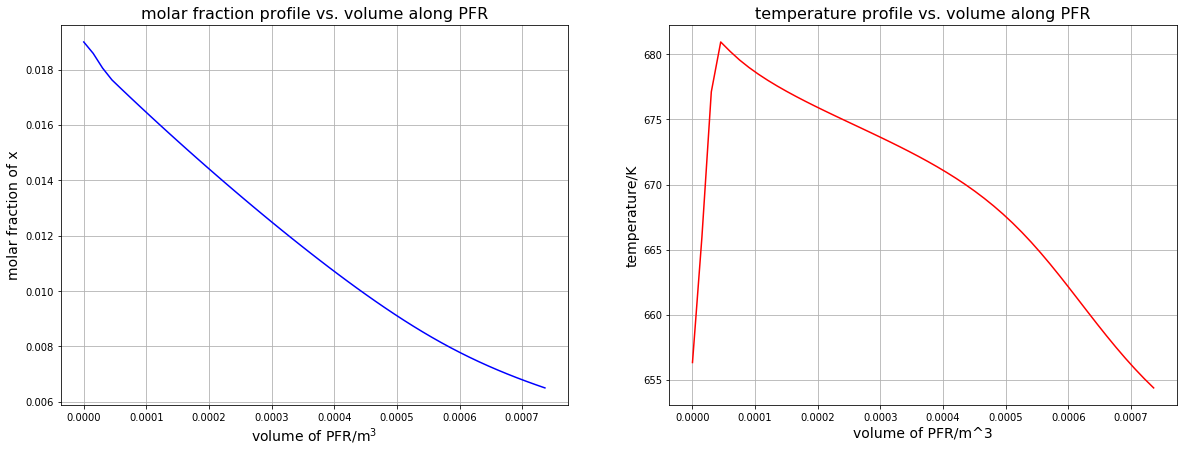

In [89]:
def PFR_E(Y, V, T_feed, TA):
    '''functions to calculate the molar flowrate & temperature profile along the PFR'''
    Fx, T = Y
    
    # include the affects of temperature on volumetric flowrate & reaction rate
    rho = Pf * 101325 * MW / 8.314 / T_feed / 1e3   # kg / m3, density
    nu0 = Q_rho / rho                               # m^3/s, inlet volume flowrate
    nu = nu0 * T / T_feed
    
    cx = Fx / nu # kmol / m^3
    
    K = K_eq(T)
    FPA = Fx_feed - Fx
    cPA = FPA / nu
    
    # taking reverse reaction into account
    r = km * np.exp(- E * (1 / T - 1 / Tm)) * (cx - cPA / K) # kmol / m^3 / s
    
    dTdV = (- DH_R * r + U * a * (TA - T)) / (Cp_hat * Q_rho) # K/s
    
    return [-r, dTdV]

def obj_E(Y, sign = 1):
    T_feed, TA = Y
    Y0 = [Fx_feed, T_feed]
    sol = odeint(PFR_E, Y0, Vspan, args = (T_feed, TA,))
    x = (Fx_feed - sol[-1, 0]) / Fx_feed # conversion
    return x * sign

sol_E = minimize (obj_E, [690, 635], args = (-1, ))

T_feed, TA = sol_E.x

print('The maximum conversion is {:1.2f} % when T_feed = {:1.2f} K, TA = {:1.2f} K.'.format(obj_E(sol_E.x) * 100, T_feed, TA))


# plot the composition & temperature profile at this T_feed & TA

plt.figure(figsize = (20, 7))

Y0 = [Fx_feed, T_feed]
sol = odeint(PFR_D, Y0, Vspan, args = (T_feed, ))

Fx = sol[:, 0]
yx = Fx / FT_feed

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(Vspan, yx, 'b-')
plt.xlabel('volume of PFR/$\mathrm{m}^3$', fontsize = 14)
plt.ylabel('molar fraction of x', fontsize = 14)
plt.title('molar fraction profile vs. volume along PFR', fontsize = 16)

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(Vspan, sol[:, 1], 'r-')
plt.xlabel('volume of PFR/m^3', fontsize = 14)
plt.ylabel('temperature/K', fontsize = 14)
plt.title('temperature profile vs. volume along PFR', fontsize = 16)
plt.show()